In [80]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import linspace

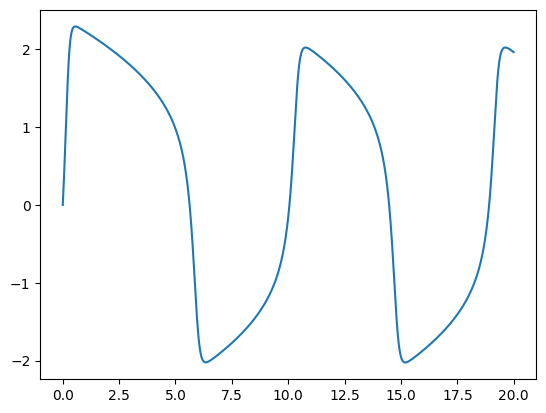

In [81]:
def vdp(t, z):
    x, y = z
    return [y, mu*(1 - x**2)*y - x]

a, b = 0, 20 # time span
mu=3
t_points=4000 # No of points of time where we wnat to see the state
t = linspace(a, b, t_points) #points of time where we want to see the position and velocity(state)
initial_conditions = [0, 6]

sol = solve_ivp(vdp, [a, b], initial_conditions, t_eval=t)
plt.plot(sol.t, sol.y[0], "-")


In [82]:
# Interpolate the solution to generate a regular time series
# Interpolation ensures that the time series is evenly spaced
interp_func_x = interp1d(sol.t, sol.y[0], kind='cubic', fill_value='extrapolate')
interp_func_y = interp1d(sol.t, sol.y[1], kind='cubic', fill_value='extrapolate')
regular_t = np.linspace(a, b, t_points)
regular_x = interp_func_x(regular_t)
regular_y = interp_func_y(regular_t)

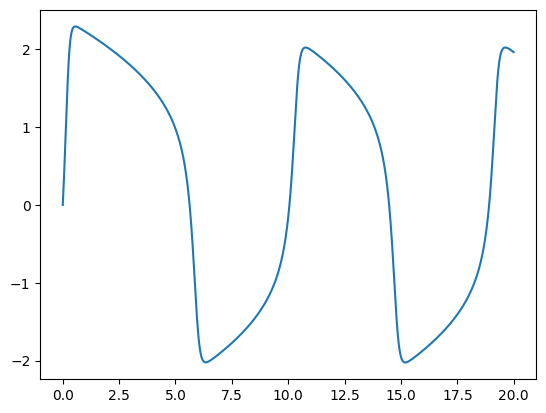

In [83]:
plt.plot(regular_t,regular_x)

In [84]:
# Calculate dx/dt and dy/dt using the Van der Pol equations
dx_dt = regular_y  # From the first equation: dx/dt = y
dy_dt = mu * (1 - regular_x**2) * regular_y - regular_x  # From the second equation: dy/dt = mu(1 - x^2)y - x

In [85]:
dataset = np.column_stack((regular_x, regular_y, dx_dt, dy_dt))
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

# Split the dataset into training, validation, and test sets
train_set = dataset[:train_size]
val_set = dataset[train_size:train_size + val_size]
test_set = dataset[train_size + val_size:]

# Check the sizes of the splits
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 3200
Validation set size: 400
Test set size: 400


In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [87]:
# Input and output columns from the dataset
X_train = train_set[:, :2]  # x and y values (state)
y_train = train_set[:, 2:]  # dx/dt and dy/dt (time derivatives)

X_val = val_set[:, :2]
y_val = val_set[:, 2:]

X_test = test_set[:, :2]
y_test = test_set[:, 2:]


In [88]:
# Model architecture
model = models.Sequential()

# Input layer: 2 input features (x and y)
model.add(layers.InputLayer(input_shape=(2,)))

# Hidden layer 1: 32 neurons
model.add(layers.Dense(32, activation='relu'))

# Physics injection: add the injection term (x * y)
# Concatenate dynamically by computing the injection term during each batch
model.add(layers.Lambda(lambda x: tf.concat([x, tf.pow(x[:, 0:1], 2) * x[:, 1:2]], axis=-1)))  # Injection of x^2 * y

# Hidden layer 2: 64 neurons
model.add(layers.Dense(64, activation='relu'))

# Hidden layer 3: 32 neurons
model.add(layers.Dense(32, activation='relu'))

# Output layer: 2 outputs (dx/dt, dy/dt)
model.add(layers.Dense(2))

In [89]:
# Compile the model using Adam optimizer and MSE loss function
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,418 (17.26 KB)

 Trainable params: 4,418 (17.26 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 19.4648 - val_loss: 0.9591
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4272 - val_loss: 1.5543
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5713 - val_loss: 0.0071
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3833 - val_loss: 0.0075
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1269 - val_loss: 0.0170
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9569 - val_loss: 0.0037
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7943 - val_loss: 0.0049
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8897 - val_loss: 0.0013
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8415 - val_loss: 0.0069
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7413 - val_loss: 0.0046
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7947 - val_loss: 7.2489e-04
Epoch 12/100
100/100 ━━━━━━━━━━━━━━

In [91]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095     
Test Loss: 0.020879041403532028


In [92]:
predictions = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


We test to see if prediction matches for first data item in test. y_test[0] and predictions[0] almost match.

In [93]:
print(X_test[0])

[-1.16736912  0.57753709]


In [94]:
print(y_test[0])

[0.57753709 0.53886323]


In [95]:
predictions[0]

array([0.5545101, 0.5583779], dtype=float32)

In [96]:
def predict_derivatives(model, state):
    # Predict the time derivatives using the trained model
    state = np.expand_dims(state, axis=0)
    return (model.predict(state))

In [97]:
time = np.arange(0, len(X_test[:,0])*0.005 ,0.005)



In [98]:
x_pred=[]
y_pred=[]
x0=X_test[0][0]
y0=X_test[0][1]

for i in time:
    x_pred.append(x0)
    y_pred.append(y0)
    returned_list=predict_derivatives(model, np.array([x0,y0]))[0]
    dx,dy=returned_list
    x0=x0+dx*0.005
    y0=y0+0.005*dy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

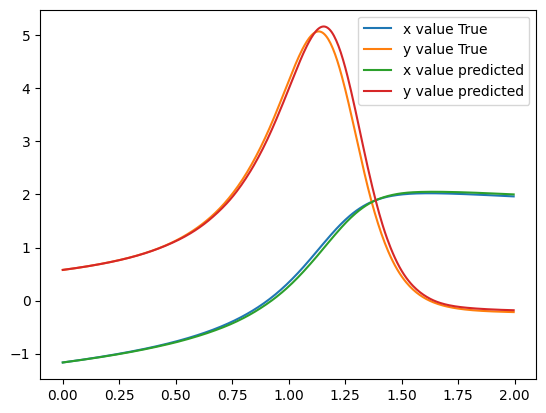

In [99]:
plt.plot(time, X_test[:,0], label="x value True")
plt.plot(time, X_test[:,1], label="y value True")
plt.plot(time,x_pred, label="x value predicted")   
plt.plot(time, y_pred, label="y value predicted")
plt.legend()